In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

import sklearn
import brainiak
import nilearn as nl
from nilearn import image, plotting, input_data

from scipy.spatial import distance

from utils import *

In [2]:
from sklearn.linear_model import LogisticRegression

pd.options.display.max_rows = 200

## TODO
- for each subject / wedding, need to figure out if it is N-or-S

# load

In [ ]:
def include_wed_and_nors_columns(df):
  """ 
  at the beginning of each trial, psychopy preloads the videos that will be shown in that trial
  from the video .mp3 file names, I extract the wedding number and path
  from the path I infer north-or-south
  I then populate every row within that trial with these info
  ** NB last wedding not included (11/12 weddings labeled)
  """
  # North paths
  path1 = ['1a','1b','2a','3a','4a','5']
  path2 = ['1a','1b','2b','3b','4b','5']
  # South paths
  path3 = ['1a','1b','2a','3b','4a','5']
  path4 = ['1a','1b','2b','3a','4b','5']
  ## initialize columns
  df['wed'] = 99
  df['NorS'] = ''
  ## find rows corresponding to trial start (preloading videos)
  begin_trial_idxL = df[df.logdata.str[:len("Created vid1a = ")]=="Created vid1a = "].index
  ## loop over trials
  for begin_trial_idx,end_trial_idx in zip(begin_trial_idxL[:-1],begin_trial_idxL[1:]):
    ## extract rows containing preloading, and use .str operations to clean
    logdata_trial_info = df.iloc[begin_trial_idx:begin_trial_idx+6]
    logdata_trial_info = logdata_trial_info.logdata.str.split(',').str[5].str.split('/').str[1]
    ## further clean
    wed_int = int(logdata_trial_info.str.split('.').str[0].values[0].split('-')[1])
    path = logdata_trial_info.str.split('.').str[1].values
    ## decide NorS label based on path
    if np.array_equal(path,path1) or np.array_equal(path,path2):
      NorS_str = 'N'
    elif np.array_equal(path,path3) or np.array_equal(path,path4):
      NorS_str = 'S'
    else:
      assert False
    ## insert into dataframe
    df.loc[begin_trial_idx:end_trial_idx,'wed'] = wed_int
    df.loc[begin_trial_idx:end_trial_idx,'NorS'] = NorS_str
  return df

# load roi

In [32]:
def load_sub_roi(sub_num,task,roi_name):
  fpath = "sub-%i_task-%s_roi-%s.npy" %(sub_num,task,roi_name)
  return np.load('fmri_data/masked/'+fpath)

In [44]:
def get_xval_split_info(logdf):
  """
  returns 
    N_TR_train_L: TRs for training on North
    S_TR_train_L: TRs for training on South
    TR_test_L: TRs for testing
    label_test_L: label for testing TRs
  each is list len 10, containing the information for an iteration of xval 
  """
  
  wed_arr = logdf.wed.unique()
  wed_arr = wed_arr[wed_arr!=99]

  N_TR_train_L = []
  S_TR_train_L = []
  TR_test_L = []
  label_test_L = []
  
  for wed_num_test in wed_arr:
    ## training 
    # remove test wed from train_wed_arr
    wed_arr_train = wed_arr[wed_arr!=wed_num_test]
    # training subset of dataframe (entries with train wedding)
    logdf_train = logdf[logdf.wed.isin(wed_arr_train)]
    # training TRs
    N_TR_train = logdf_train[logdf_train.NorS=='N'].TR.unique()
    S_TR_train = logdf_train[logdf_train.NorS=='S'].TR.unique()
    N_TR_train_L.append(N_TR_train)
    S_TR_train_L.append(S_TR_train)
    ## testing TRs
    logdf_test = logdf[(logdf.wed == wed_num_test)]
    TR_test = logdf_test.TR.unique()
    label_test = logdf_test.NorS.unique() 
    TR_test_L.append(TR_test)
    label_test_L.append(label_test[0])
  return N_TR_train_L,S_TR_train_L,TR_test_L,label_test_L
  

In [60]:
ROI_NAME_L

['rsherlockAvg_fc_thr5_pmc',
 'rsherlockAvg_fc_thr5_mpfc',
 'rsherlockAvg_fc_thr5_lTPJ',
 'rsherlockAvg_fc_thr5_rTPJ',
 'rsherlockAvg_fc_thr5_lSFG',
 'rsherlockAvg_fc_thr5_rSFG',
 'rhippocampusL_AAL',
 'rhippocampusR_AAL',
 'rhippocampusAAL']

In [82]:
""" 
CLASSIFIER CROSS VALIDATION
"""

fdir = 'fmri_data/xval/sweep1/'
task = 'videos'
roi_name = 'rsherlockAvg_fc_thr5_pmc'

for roi_name in ROI_NAME_L:
  print(roi_name)
  accL = []
  for sub_num in SUB_NS:
    print(sub_num)
    roi_act = load_sub_roi(sub_num,task,roi_name)
    sub_accL = []
    ## xval split
    for N_TR_train,S_TR_train,TR_test,label_test in zip(*get_xval_split_info(logdf)):
      # split roi act into train and test
      roi_act_N_train = roi_act[N_TR_train,:]
      roi_act_S_train = roi_act[S_TR_train,:]
      roi_act_test = roi_act[TR_test,:]
      # form classifier datasets
      X_train = np.concatenate([roi_act_N_train,roi_act_S_train])
      X_test = roi_act_test
      Y_train = np.concatenate([np.ones(len(roi_act_N_train)),np.zeros(len(roi_act_S_train))])
      Y_test = np.repeat(int(label_test == 'N'),len(X_test))
      clf = sklearn.linear_model.LogisticRegression(solver='liblinear').fit(X_train,Y_train)
      sub_accL.append(clf.score(X_test,Y_test))
      yhat = clf.predict_proba(X_test)
#       print(clf.score(X_test,Y_test),clf.score(X_train,Y_train))
    accL.append(sub_accL)

  fpath = fdir+'acc-%s'%roi_name
  np.save(fpath,np.array(accL))


rsherlockAvg_fc_thr5_pmc
30
31
32
33
34
35
36
37
38
rsherlockAvg_fc_thr5_mpfc
30
31
32
33
34
35
36
37
38
rsherlockAvg_fc_thr5_lTPJ
30
31
32
33
34
35
36
37
38
rsherlockAvg_fc_thr5_rTPJ
30
31
32
33
34
35
36
37
38
rsherlockAvg_fc_thr5_lSFG
30
31
32
33
34
35
36
37
38
rsherlockAvg_fc_thr5_rSFG
30
31
32
33
34
35
36
37
38
rhippocampusL_AAL
30
31
32
33
34
35
36
37
38
rhippocampusR_AAL
30
31
32
33
34
35
36
37
38
rhippocampusAAL
30
31
32
33
34
35
36
37
38


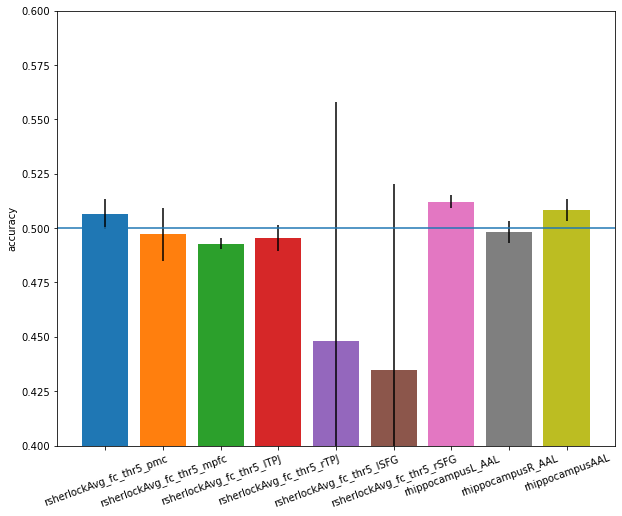

In [114]:
fdir = 'fmri_data/xval/sweep1/'

plt.figure(figsize=(10,8))
ax = plt.gca()
for idx,roi_name in enumerate(ROI_NAME_L):
  fpath = fdir+'acc-%s.npy'%roi_name
  acc = np.load(fpath)
  acc2 = acc.mean(0)
  M = acc2.mean()
  S = acc2.std()/np.sqrt(len(acc2))
  ax.bar(idx,M,yerr=S)
ax.set_ylim(0.4,0.6)
ax.axhline(0.5)
ax.set_xticks(range(9))
ax.set_xticklabels(ROI_NAME_L,rotation=20)
ax.set_ylabel('accuracy')

plt.savefig('figures/view_xval_acc')

In [266]:
def mov_avg(X,w):
  A = np.ones(len(X)-w)
  for i in range(len(X)-w):
    A[i] = X[i:i+w].mean()
  return A

In [273]:
yhat_pr = clf.predict_proba(roi_act)[:,1]
yhat_plt = mov_avg(yhat_pr,30)

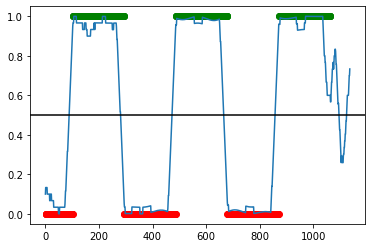

In [276]:
plt.plot(yhat_plt)
plt.scatter(NTR,np.ones(len(NTR)),c='g')
plt.scatter(STR,np.zeros(len(STR)),c='r')
plt.axhline(0.5,c='k')